# Project Title
### Data Engineering Capstone Project

#### Project Summary

The project consists of creating a data model following a star schema that contains data about immigrants moving to/from US cities. The data model will contain not only information about immigrants but also information about US cities demographics as well as their airports.<br>
The main challenge of this project is to clean and transform data from different sources to generate a data model that represents a unique ground truth about the data and that will be used for analytical processes.<br>
Once the data model is ready for processing, we can get insights such as what cities are prefered by immigrants and we can even filter by age, race and many other dimensions. We can also check if the available airports in the cities can handle the flow of immigrants.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
from utils import *
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import configparser
import os

### Step 1: Scope the Project and Gather Data

#### Scope

During the next steps, I will read the data and check if there are any anomalies such as missing data and duplicates.<br> Next, I will define a data model following a star schema, then, I will run data pipelines to aggregate the data by cities and generate dimension and fact tables.<br> Finally, I will check the quality of the data and write the tables as parquet files on S3 which is going to be the final form or output of this project. During these steps I will use pandas and pyspark for data processing. pyspark will be extremely helpful especially when processing the immigration dataset which contains over 3 million rows/samples.

#### Data Description

Our data is derived from 3 sources or files as follows:
* [I94 Immigration Data](https://travel.trade.gov/research/reports/i94/historical/2016.html): This data comes from the US National Tourism and Trade Office. It contains detailed information about visitors arrival/departure to/from US states during the period of april 2016.
* [U.S. City Demographic Data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/): This data comes from OpenSoft. It contains detailed demographic statistics for each state and city in the US.
* [Airport Code Table](https://datahub.io/core/airport-codes#data): This data contains table of airport codes and corresponding cities.

In [2]:
spark = sparkContext()

In [3]:
#read immigrants data

fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
#fname = 'csv_data/immigration_data_sample.csv'
immigration = spark.read.format('com.github.saurfang.sas.spark').load(fname, inferSchema=True)
#immigration = spark.read.csv(fname, header=True, inferSchema=True).drop('_c0')

In [4]:
#read immigration data

fname = 'csv_data/us-cities-demographics.csv'
demographics = spark.read.csv(fname, sep=';', header='true', inferSchema=True)

In [5]:
#read airports data

fname = 'csv_data/airport-codes_csv.csv'
airport = spark.read.csv(fname, header='true', inferSchema=True)

### Step 2: Explore and Assess the Data

#### Cleaning Steps
Steps necessary to clean the data

1. check and drop duplicated data
2. drop features with nans over 80%
3. drop rows with only nans
4. check statistical anomalies and fields format(iso_region for airport data)

##### Explore and Clean Airport Data

In [6]:
airport = dataExplorationCleanining(
    airport,
    'airport',
    duplicates_fields=['ident'],
    show=True
)

									*********** AIRPORT Basic Data Exploration and Cleaning ***********

----------- AIRPORT Top 5 Rows --------------

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+----------+--------------------+
| 06IN|       closed|Ellis Fly-In Airport|         575|       NA|         US|     US-IN|   Blackhawk|    null|      null|-87.303596, 39.28...|
| 06VA|small_airport|   Mount Horeb Field|        1160|       NA|         US|     US-VA|    Grottoes|    06VA|      06VA|-78.8553009033203...|
| 0LA0|     heliport|West Hackberry He...|          10|       NA|         US|     US-LA|   Hackberry|    0LA0|      0LA0|-93.4001998901367...|
| 0MD6|small_airp

##### checking fields anomalies for airports

In [7]:
airport.select(['elevation_ft']).summary().show()

+-------+------------------+
|summary|      elevation_ft|
+-------+------------------+
|  count|             48069|
|   mean|1240.7896773388254|
| stddev| 1602.363459348408|
|    min|             -1266|
|    25%|               205|
|    50%|               718|
|    75%|              1498|
|    max|             22000|
+-------+------------------+



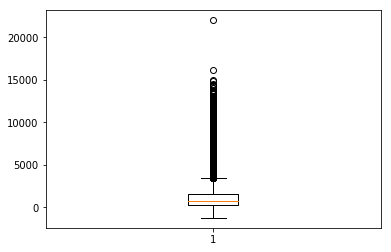

In [8]:
plt.boxplot(airport.select(['elevation_ft']).toPandas().dropna().values);

In [9]:
airport.select(['elevation_ft', 'type', 'name']).where(col('elevation_ft')  > 15000).collect()

[Row(elevation_ft=22000, type='heliport', name='Siachen Glacier AFS Airport'),
 Row(elevation_ft=16200, type='small_airport', name='Daulat Beg Oldi Advanced Landing Ground')]

## Explore us cities demographics

In [10]:
demographics = dataExplorationCleanining(
    demographics,
    'demographics',
    duplicates_fields=['City', 'State Code', 'Race'],
    show=True
)

									*********** DEMOGRAPHICS Basic Data Exploration and Cleaning ***********

----------- DEMOGRAPHICS Top 5 Rows --------------

+----------------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|            City|     State|Median Age|Male Population|Female Population|Total Population|Number of Veterans|Foreign-born|Average Household Size|State Code|                Race|Count|
+----------------+----------+----------+---------------+-----------------+----------------+------------------+------------+----------------------+----------+--------------------+-----+
|         Bayonne|New Jersey|      39.7|          32705|            33598|           66303|              2225|       21899|                  2.62|        NJ|Black or African-...| 7581|
|          Canton|      Ohio|      33.4|          34476|            37419|           71895|              3404|        2204|  

In [11]:
selected_fields=[
    'Median Age', 'Male Population',
    'Female Population', 'Total Population',
    'Number of Veterans', 'Foreign-born',
    'Average Household Size', 'Count'
]
demographics.select(selected_fields).summary().show()

+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+----------------------+------------------+
|summary|       Median Age|  Male Population| Female Population|  Total Population|Number of Veterans|      Foreign-born|Average Household Size|             Count|
+-------+-----------------+-----------------+------------------+------------------+------------------+------------------+----------------------+------------------+
|  count|             2891|             2888|              2888|              2891|              2878|              2878|                  2875|              2891|
|   mean|35.49488066413007|97328.42624653739|101769.63088642659|198966.77931511588| 9367.832522585128|40653.598679638635|     2.742542608695653| 48963.77447250087|
| stddev|4.401616730099887| 216299.936928733|231564.57257148283|447555.92963359045| 13211.21992386409| 155749.1036650984|    0.4332910878973049|144385.58856460612|
|    min|       

## Explore immigration data

In [12]:
immigration = dataExplorationCleanining(
    immigration,
    'immigration',
    duplicates_fields=['cicid'],
    show=True
)

									*********** IMMIGRATION Basic Data Exploration and Cleaning ***********

----------- IMMIGRATION Top 5 Rows --------------

+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|entdepa|entdepd|matflag|biryear| dtaddto|gender|airline|         admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+--------+------+-------+---------------+-----+--------+
|299.0|2016.0|   4.0| 103.0| 103.0|    NYC|20545.0|    1.0|     NY|20550.0|  54.0|    2.0|  1.0|20160401|    null|      O|      O|      M| 1962.0|06292016|  null|     OS|5.5425872433E10|00087|      WT|
|305.0|2016.0|   4.0| 103.0| 103.0|    NYC|20545.0|    1.0|

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

![image](https://drive.google.com/uc?export=view&id=1krP58ZqA2qFRXoXVvoxK-s8Cc18YBDO7)

The data model is a star schema model. It consists of 3 dimension tables:<br>
- dim_cities_airport: contains airport information aggregated by cities.
- dim_cities_demographics: contains statistical data about cities demographics and aggregated by cities.
- dim_time: contains features extracted from the immigration dates such as year, month, weekday etc.<br>
As well as a fact table (fact_immigration) which contains information about each immigrant.<br>

The star schema model was the preferred choice as we can get analytical insights using a few joins.<br>
Also, the aggregation by cities of both dim_cities_airport and dim_cities_demographics dimension tables was a good choice for this model, as it is the only possible way to link the immigration data with both dimensions (airports and cities demographics).<br>
Aggregating airports by cities made it possible to link each row from the fact table (extracted from the immigration dataset) with each row from both dim_cities_airport and dim_cities_demographics dimension tables.

#### 3.2 Mapping Out Data Pipelines
The steps necessary to pipeline the data into the chosen data model are as follows:
- Generate the cities airport dimension table (<b>dim_cities_airports</b>):
    1. Check and rectify the iso_region column format and filter the airports to keep only U.S airports.
    2. Drop any nan value in the "municipality" feature and transform it to lower case.
    3. Select airport fields and rename them, generate primary key.
    4. Aggregate airports by cities.
    5. Create the dim_cities_airport view
<br>

- Generate the cities demographics dimension table (<b>dim_cities_demographics</b>):
    1. Generating race features and aggregate them by cities.
    2. generating primary key composed of cities and state_codes.
    3. rename columns
    4. create the dim_cities_demographics view
<br>
 
- Generate the time dimension table (<b>dim_time</b>):
    1. Drop nans from arrival and departure dates (from immigration dataset) and convert them from SAS to date format.
    2. Extracts features suchs as month, weekofyear, isweekend ...etc. from both arrival and departure date.
    3. Create the dim_time view.
<br>

- Generate the immigration fact table (<b>fact_immigration</b>):
    1. Extract a map of (field --> value) from the I94_SAS_Labels_Descriptions.SAS file and decode columns of the immigration dataset.
    2. Extracts the city name from the 'i94port' column after decoding in step1.
    3. Drop nans from arrival and departure dates (from immigration dataset) and convert them from SAS to date format.
    4. Select a set of columns to be included in the fact table.
    5. Set all city values to lower case and all state_code values to upper case.
    6. Create the fact_immigration view and join it with the time, cities_dimographics and cities_airports

### Step 4: Pipelines to Model the Data 
#### 4.1 Data model


In [13]:
def process_dim_cities_airports(spark, airport):
    """
    Aggregates airport dataset by cities and generates the cities_airport dimension.
    ---
    
    args:
        spark(SparkSession): a SparkSession object used to run spark tasks on a distributed cluster. 
        airport(Spark.DataFrame): a spark dataframe of airports data.
        
    returns:
        dim_cities_airport(Spark.DataFrame): cities_airport dimension table.
    """
    
    #airport.createOrReplaceTempView('airport')

    ##### step1: check and rectify the iso_region column format and filter the airports to keep only U.S airports. 
    airport = airport.withColumn('iso_region', IsoRegionFormatCheck('iso_region'))    
    airport = airport.filter(col('iso_country')=='US')
    
    ###### step2: drop any nan value in the "municipality" feature and transform it to lower case.
    airport = airport.withColumn('municipality', lower(col('municipality')))
    airport = airport.dropna(subset=['municipality'])
    
    
    ###### step3: select airport fields and rename them, generate primary key.
    airport.createOrReplaceTempView('airport')
    airport = spark.sql("""
        SELECT CONCAT(SUBSTR(iso_region, 4, 2), ', ', municipality) dim_airport_pk, 
        elevation_ft, name, type, municipality city, 
        SUBSTR(iso_region, 4, 2) state_code
        From airport
    """)
    
    ##### step4: aggregate airports by cities.
    airport_pd = airport.toPandas()
    dim_cities_airport = pd.concat(
        [
            pd.get_dummies(airport_pd.type),
            airport_pd[[
                'dim_airport_pk','state_code', 
                'city', 'elevation_ft', 'name'
            ]]
        ]
        , axis=1
    ).groupby(
        ['dim_airport_pk', 'state_code', 'city']
        , as_index=False
    ).agg({
        'large_airport':sum,
        'medium_airport':sum,
        'small_airport':sum,
        'balloonport':sum,
        'seaplane_base':sum,
        'heliport':sum,
        'closed':sum,
        'name':'count',
        'elevation_ft':'mean',
    }).rename(
        {
        'large_airport':'total_large_airport',
        'medium_airport':'total_medium_airport',
        'small_airport':'total_small_airport',
        'balloonport':'total_balloonport',
        'seaplane_base':'total_seaplane_base',
        'heliport':'total_heliport',
        'closed':'total_closed',
        'name':'total_airports',
        'elevation_ft':'avg_elevation_ft',
        }
        , axis=1
    )
    
    #### step5: create dim_cities_airport view.
    dim_cities_airport = spark.createDataFrame(dim_cities_airport)
    dim_cities_airport.createOrReplaceTempView('dim_cities_airport')
    
    return dim_cities_airport

In [14]:
def process_dim_cities_demographics(spark, demographics):
    """
    Aggregates data by cities and generates the cities_demographics dimension.
    ---
    
    args:
        spark(SparkSession): a SparkSession object used to run spark tasks on a distributed cluster. 
        demographics(Spark.DataFrame): a spark dataframe of demographics data.
    
    returns:
        dim_cities_demographics(Spark.DataFrame): cities_demographics dimension table. 
    """
    
    #### step1: generating race features and aggregate them by cities.
    demographics_pd = demographics.toPandas()

    cities_race_stats = pd.get_dummies(
        demographics_pd['Race'],
        prefix='', 
        prefix_sep=''
    ).multiply(
        demographics_pd.Count, 
        axis=0
    )
    
    cities_race_stats = pd.concat(
        [
            demographics_pd[['State Code', 'City']], 
            cities_race_stats
        ]
        , axis=1
    ).groupby(
        ['State Code', 'City']
        , as_index=False
    ).sum()

    dim_cities_demographics = demographics_pd.drop(
        ['Race', 'Count'], axis=1
    ).drop_duplicates()
    
    dim_cities_demographics = dim_cities_demographics.merge(
    cities_race_stats, 
    on=['City', 'State Code'], 
    how='inner' 
    )

    
    #### step2: generating primary key composed of cities and state_codes.
    dim_cities_demographics.City = dim_cities_demographics.City.str.lower()
    dim_cities_demographics['State Code'] = dim_cities_demographics['State Code'].str.upper()
    dim_cities_demographics['dim_cities_demographics_pk'] = dim_cities_demographics['State Code']\
                                                        + ', '\
                                                        + dim_cities_demographics['City']

    #### step3: rename columns.
    column_labels = {
        'State Code':'state_code', 
        'State':'state', 
        'City':'city', 
        'Median Age':'median_age', 
        'Male Population':'male_population',
        'Female Population':'female_population', 
        'Total Population':'total_population',
        'Number of Veterans':'number_of_veterans', 
        'Foreign-born':'foreign_born', 
        'Average Household Size':'average_household_size',
        'American Indian and Alaska Native':'american_indian_and_alaska_native_population', 
        'Asian':'asian_population', 
        'Black or African-American':'black_or_african_american_population', 
        'Hispanic or Latino':'hispanic_or_latino_population', 
        'White':'white_population'
    }
    dim_cities_demographics.rename(column_labels, axis=1, inplace=True)
    
    #### step4 : create dim_cities_demographics view.
    dim_cities_demographics = spark.createDataFrame(dim_cities_demographics)
    dim_cities_demographics.createOrReplaceTempView('dim_cities_demographics')
    
    return dim_cities_demographics

In [15]:
def process_dim_time(spark, immigration):
    """
    Generates the time dimension which includes all arrival and departure
    dates from the immigration data.
    ---
    
    args:
        spark(SparkSession): a SparkSession object used to run spark tasks on a distributed cluster. 
        immigration(Spark.DataFrame): a spark dataframe of immigration data.
    
    returns:
        dim_time(Spark.DataFrame): time dimension table.
    """
    
    #### step1: drop nans from arrival and departure dates (from immigration dataset) and convert them from SAS to date format.
    date_fields = ['arrdate', 'depdate']
    immigration = immigration.dropna(subset=(date_fields))
    immigration = immigration.withColumn('arrdate', convertSaS_toDate(col('arrdate')))
    immigration = immigration.withColumn('depdate', convertSaS_toDate(col('depdate')))
    immigration.createOrReplaceTempView('immigration')
 
    #### step2: extracts features suchs as month, weekofyear, isweekend ...etc. from both arrival and departure date.
    dim_time = spark.sql("""
        SELECT DISTINCT
            arrival_date_pk, 
            YEAR(arrival_date_pk) as year, 
            MONTH(arrival_date_pk) as month, 
            DAY(arrival_date_pk) as day, 
            WEEKOFYEAR(arrival_date_pk) as weekofyear, 
            DAYOFWEEK(arrival_date_pk) as weekday, 
            QUARTER(arrival_date_pk) as season,
            (CASE
               WHEN DAYOFWEEK(arrival_date_pk) IN (7,1)
               THEN 1
               ELSE 0
            END) as is_weekend
        FROM (
            SELECT DISTINCT arrdate as arrival_date_pk
            FROM immigration
            WHERE arrdate IS NOT NULL
            UNION
            SELECT DISTINCT depdate as arrival_date_pk
            FROM immigration
            WHERE depdate IS NOT NULL
        )
        ORDER BY arrival_date_pk ASC
    """)
    
    #### step3: create a view of the time dimension. 
    dim_time.createOrReplaceTempView('dim_time')
    return dim_time

In [16]:
def  process_fact_immigration(spark, immigration):
    """
    Process immigration data to generate the immigration fact table
    and join it with the dimension tables to get the foreign keys.
    ---
    
    args:
        spark(SparkSession): a SparkSession object used to run spark tasks on a distributed cluster. 
        immigration(Spark.DataFrame): a spark dataframe of immigration data.
        
    returns:
        fact_immigration(Spark.DataFrame): immigration fact table.
    """
    
    #### step1: extract a map of (field --> value) from the I94_SAS_Labels_Descriptions.SAS file
    ####        and decode columns of the immigration dataset.
    
    all_fields_maps = map_features_extraction('I94_SAS_Labels_Descriptions.SAS')
    immigration = immigration.withColumn('i94cit', col('i94cit').cast('string'))\
                             .replace(all_fields_maps['i94cit'], subset=['i94cit'])
    immigration = immigration.withColumn('i94res', col('i94res').cast('string'))\
                             .replace(all_fields_maps['i94cit'], subset=['i94res'])
    immigration = immigration.withColumn('i94mode', col('i94mode').cast('string'))\
                             .replace(all_fields_maps['i94mode'], subset=['i94mode'])
    immigration = immigration.withColumn('I94VISA', col('I94VISA').cast('string'))\
                             .replace(all_fields_maps['I94VISA'], subset=['I94VISA'])
    immigration = immigration.replace(all_fields_maps['i94port'], subset=['i94port'])
    
    #### step2: extracts the city name from the 'i94port' column after decoding in step1.
    immigration = immigration.withColumn('city', extract_city(col('i94port')))

    #### step3: drop nans from arrival and departure dates (from immigration dataset) and convert them from SAS to date format.
    date_fields = ['arrdate', 'depdate']
    immigration = immigration.dropna(subset=(date_fields))
    immigration = immigration.withColumn('arrdate', convertSaS_toDate(col('arrdate')))
    immigration = immigration.withColumn('depdate', convertSaS_toDate(col('depdate')))

    #### step4: select a set of columns to be included in the fact table.
    selected_fields = [
        'cicid', 'arrdate', 'depdate', 'i94cit', 
        'i94res', 'biryear', 'gender', 'i94mode',
        'airline', 'fltno', 'visatype', 
        'i94visa', 'i94addr', 'city'
    ]
    fact_immigration = immigration.select(selected_fields)
    
    #### step5: set all city values to lower case and all state_code values to upper case.
    fact_immigration = fact_immigration.withColumn('city', lower(col('city')))
    fact_immigration = fact_immigration.withColumn('i94addr', upper(col('i94addr')))\
                                       .withColumnRenamed('i94addr', 'state_code')
    
    #### step6: create a view of the immigration fact table and join it with the time, cities_dimographics and cities_airports
    ####        dimensions tables to add the foreign keys. 
    fact_immigration.createOrReplaceTempView('fact_immigration')
    
    fact_immigration = spark.sql("""
        SELECT DISTINCT aprt.dim_airport_pk dim_airport_fk, 
        dem.dim_cities_demographics_pk dim_cities_demographics_fk, 
        time.arrival_date_pk arrival_date_fk, cicid cicid_pk, depdate departure_date, 
        i94cit, i94res, biryear, gender, airline, fltno, 
        visatype, i94visa, i94mode
        FROM fact_immigration as im
        JOIN dim_cities_demographics as dem
        ON (im.state_code = dem.state_code) and (im.city = dem.city)
        JOIN dim_cities_airport as aprt
        ON (im.state_code = aprt.state_code) and (im.city = aprt.city)
        JOIN dim_time as time
        ON (im.arrdate = time.arrival_date_pk)
    """)
    
    return fact_immigration

##### Run Data Model Pipeline

In [17]:
#create views
airport.createOrReplaceTempView('airport')
immigration.createOrReplaceTempView('immigration')
demographics.createOrReplaceTempView('demographics')

In [18]:
dim_cities_airports = process_dim_cities_airports(spark, airport)
dim_cities_airports.printSchema()
dim_cities_airports.limit(5).toPandas()

root
 |-- dim_airport_pk: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- city: string (nullable = true)
 |-- total_large_airport: long (nullable = true)
 |-- total_medium_airport: long (nullable = true)
 |-- total_small_airport: long (nullable = true)
 |-- total_balloonport: long (nullable = true)
 |-- total_seaplane_base: long (nullable = true)
 |-- total_heliport: long (nullable = true)
 |-- total_closed: long (nullable = true)
 |-- total_airports: long (nullable = true)
 |-- avg_elevation_ft: double (nullable = true)



,dim_airport_pk,state_code,city,total_large_airport,total_medium_airport,total_small_airport,total_balloonport,total_seaplane_base,total_heliport,total_closed,total_airports,avg_elevation_ft
0,"AK, adak island",AK,adak island,0,1,0,0,0,0,0,1,18.0
1,"AK, akhiok",AK,akhiok,0,0,1,0,0,0,0,1,44.0
2,"AK, akiachak",AK,akiachak,0,0,1,0,1,0,0,2,11.5
3,"AK, akiak",AK,akiak,0,0,1,0,0,0,0,1,30.0
4,"AK, akutan",AK,akutan,0,0,1,0,1,0,0,2,NaN


In [19]:
dim_cities_demographics = process_dim_cities_demographics(spark, demographics)
dim_cities_demographics.printSchema()
dim_cities_demographics.limit(5).toPandas()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: double (nullable = true)
 |-- female_population: double (nullable = true)
 |-- total_population: long (nullable = true)
 |-- number_of_veterans: double (nullable = true)
 |-- foreign_born: double (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- american_indian_and_alaska_native_population: long (nullable = true)
 |-- asian_population: long (nullable = true)
 |-- black_or_african_american_population: long (nullable = true)
 |-- hispanic_or_latino_population: long (nullable = true)
 |-- white_population: long (nullable = true)
 |-- dim_cities_demographics_pk: string (nullable = true)



,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,american_indian_and_alaska_native_population,asian_population,black_or_african_american_population,hispanic_or_latino_population,white_population,dim_cities_demographics_pk
0,bayonne,New Jersey,39.7,32705.0,33598.0,66303,2225.0,21899.0,2.62,NJ,0,7171,7581,19525,41431,"NJ, bayonne"
1,canton,Ohio,33.4,34476.0,37419.0,71895,3404.0,2204.0,2.32,OH,358,0,21353,3597,53571,"OH, canton"
2,carlsbad,California,42.1,55119.0,58347.0,113466,6031.0,17689.0,2.68,CA,1513,11948,876,12969,98705,"CA, carlsbad"
3,colorado springs,Colorado,34.8,225544.0,231018.0,456562,49291.0,35320.0,2.48,CO,11146,22619,38976,78711,374900,"CO, colorado springs"
4,des moines,Iowa,34.5,103726.0,106591.0,210317,11780.0,23857.0,2.41,IA,3964,15205,26353,25306,168057,"IA, des moines"


In [20]:
dim_time = process_dim_time(spark, immigration)
dim_time.printSchema()
dim_time.limit(5).toPandas()

root
 |-- arrival_date_pk: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- season: integer (nullable = true)
 |-- is_weekend: integer (nullable = false)



,arrival_date_pk,year,month,day,weekofyear,weekday,season,is_weekend
0,2001-07-20,2001,7,20,29,6,3,0
1,2012-04-12,2012,4,12,15,5,2,0
2,2012-04-14,2012,4,14,15,7,2,1
3,2014-04-22,2014,4,22,17,3,2,0
4,2014-04-24,2014,4,24,17,5,2,0


In [21]:
fact_immigration = process_fact_immigration(spark, immigration)
fact_immigration.printSchema()
fact_immigration.show(5)

not enough values to unpack (expected 2, got 1)  value: ;

root
 |-- dim_airport_fk: string (nullable = true)
 |-- dim_cities_demographics_fk: string (nullable = true)
 |-- arrival_date_fk: date (nullable = true)
 |-- cicid_pk: double (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- i94cit: string (nullable = true)
 |-- i94res: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)
 |-- i94visa: string (nullable = true)
 |-- i94mode: string (nullable = true)

+--------------+--------------------------+---------------+---------+--------------+--------------+--------------+-------+------+-------+-----+--------+--------+-------+
|dim_airport_fk|dim_cities_demographics_fk|arrival_date_fk| cicid_pk|departure_date|        i94cit|        i94res|biryear|gender|airline|fltno|visatype| i94visa|i94mode|
+--------------

#### 4.2 Data Quality Checks
 
Quality Checks

- Unique primary keys check

In [22]:
def unique_key_check(spark_data, spark_data_label, key):
    """
    Checks if a key is unique or not by printing a message.
    ---
    
    args:
        spark_data(Spark.DataFrame): spark dataframe representing a fact or dimension table.
        spark_data_label(string): the dataframe label.
        key(string): the unique key field.
    
    returns:
        None.
    """
    
    if spark_data.count() - spark_data.select(key).distinct().count() == 0:
        print(f'{spark_data_label}: unique primary key test passed')
    else:
        print(f'{spark_data_label}: unique primary key test failed!')

In [ ]:
unique_key_check(fact_immigration, 'fact_immigration', 'cicid_pk')
unique_key_check(dim_time, 'dim_time', 'arrdate_pk')
unique_key_check(dim_cities_demographics, 'dim_cities_demographics', 'dim_cities_demographics_pk')
unique_key_check(dim_cities_airports, 'dim_cities_airports', 'dim_airport_pk')

 - Check if there are any nans in primary and foreign keys

In [ ]:
def check_missing_values(spark_data, spark_data_label, subset):
    """
    Counts the missing values of a spark data frame primary/foreign keys
    and prints a message to indicate if the test passed or not.
    ---
    
    args:
        spark_data(Spark.DataFrame): spark dataframe representing a fact or dimension table.
        spark_data_label(string): the dataframe label.
        subset(list): a list of one or multiple column names.
    
    returns:
        None.
    """
    print(f"""
        {spark_data_label} keys missing values test passed.
    """
    if spark_data.select([
        (count(when(col(c).isNull(), c))/count(lit(1))).alias(c) 
        for c in subset
    ]).toPandas().sum().sum() == 0 else f"""
        {spark_data_label}: keys missing values test failed!
        """
    )

In [ ]:
check_missing_values(fact_immigration, 'fact_immigration', ['cicid_pk', 'arrdate_fk', 'dim_cities_demographics_fk', 'dim_airport_fk'])
check_missing_values(dim_time, 'dim_time', ['arrdate_pk'])
check_missing_values(dim_cities_demographics, 'dim_cities_demographics', ['dim_cities_demographics_pk'])
check_missing_values(dim_cities_airports, 'dim_cities_airports', ['dim_airport_pk'])

- Check if tables are not empty

In [ ]:
print(f' dim_time rows: {dim_time.count()}')
print(f'dim_cities_airports rows: {dim_airports.count()}')
print(f'dim_cities_demographics: {dim_cities_demographics.count()}')
print(f'fact_immigration rows: {fact_immigration.count()}')

#### Write Data Model to S3

In [ ]:
# AWS configuration
config = configparser.ConfigParser()
config.read('aws_config.cfg', encoding='utf-8-sig')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']
output_path = config['S3']['S3_BUCKET']

In [ ]:
#write airports to S3 and partition data by sate_code and city.
dim_cities_airports.write.partitionBy('state_code', 'city')\
                     .mode('overwrite')\
                     .parquet(os.path.join(output_path, 'dim_cities_airports'))

#write dim_cities_demographics to S3 and partition data by sate_code and city.
dim_cities_demographics.write.partitionBy('state_code', 'city')\
                     .mode('overwrite')\
                     .parquet(os.path.join(output_path, 'dim_cities_demographics'))

#write dim_time to S3.
dim_time.write.mode('overwrite')\
              .parquet(os.path.join(output_path, 'dim_time'))

#write fact_immigration to S3 and partition data by airport foreign key (dim_airport_fk).
fact_immigration.write.partitionBy('dim_airport_fk')\
                      .mode('overwrite')\
                      .parquet(os.path.join(output_path, 'fact_immigration'))

#### 4.3 Data dictionary 

<b> dim_cities_demographics: </b><br>
* <b>dim_cities_demographics_pk:</b> Dimension table pripary key composed of state_code + city label.
* <b>city:</b> City label.
* <b>state:</b> State label.
* <b>state_code:</b> 2 character unique state code.
* <b>median_age:</b> City population median age.
* <b>male_population:</b> Total number of the city male population.
* <b>female_population:</b> Total number of the city female population.
* <b>total_population:</b> Total number of city population.
* <b>number_of_veterans:</b> Total number of city veterans.
* <b>foreign_born:</b> Total number of city foreign borns.
* <b>average_household_size:</b> Average of persons per household per city.
* <b>hispanic_or_latino_population:</b> Total number of hispanic or latino race population per city.
* <b>white_population:</b> Total number of white race population per city.
* <b>asian_population:</b> Total number of asian race population per city.
* <b>black_or_african_american_population:</b> Total number of black or african american race population per city.
* <b>american_indian_and_alaska_native_population:</b> Total number of american indian and alaska native race population per city.

<b> dim_cities_airports: </b><br>
* <b>dim_airport_pk:</b> Dimension table pripary key composed of state_code + city label.
* <b>city:</b> City label.
* <b>state_code:</b> 2 character unique state code.
* <b>total_large_airport:</b> Total number of large airports per city.
* <b>total_medium_airport:</b> Total number of medium airports per city.
* <b>total_small_airport:</b> Total number of small airports per city.
* <b>total_balloonport:</b> Total number of balloon port pere city.
* <b>total_seaplane_base:</b> Total number of seaplane bases per city.
* <b>total_heliport:</b> Total number of heliport per city.
* <b>total_airports:</b> Total number of active airports per city.
* <b>total_closed:</b> Total number of closed airports per city.
* <b>avg_elevation_ft:</b> Average of airports/bases elevation feat per city.

<b> dim_time: </b><br>
* <b>arrival_date_pk:</b> Dimension table pripary key representing arrival and departure dates.
* <b>year:</b> Date year, extracted from the arrival/departure date.
* <b>month:</b> Month of the year, extracted from the arrival/departure date.
* <b>day:</b> Day of month, extracted from the arrival/departure date.
* <b>weekday:</b> Day of week, extracted from the arrival/departure date.
* <b>weeofyear:</b> indicates the week year number.
* <b>season:</b> The season of the year, extracted from the arrival/departure date.
* <b>isweekend:</b> indicates whether a day is a week-end or not.

<b> fact_immigration: </b><br>
* <b>cicd_pk:</b> immigration fact primary key, indicates whether a day is a week-end or not.
* <b>arrival_date_fk:</b> immigration fact foreign key, links the fact table with the time dimension.
* <b>dim_airport_fk:</b>  immigration fact foreign key, links the fact table with the cities_airports dimension.
* <b>dim_cities_demographics_fk:</b>  immigration fact foreign key, links the fact table with the cities_demographics dimension.
* <b>departure_date:</b> the departure date from the US.
* <b>i94res:</b> immigrant residence country.
* <b>i94cit:</b> immigrant birth country.
* <b>biryear:</b> 4 digit year of birth.
* <b>gender:</b> non-immigrant sex.
* <b>airline:</b> airline used to arrive in U.S.
* <b>fltno:</b> the flight number.
* <b>i94visa:</b> visa codes indicating the reason for the immigration/travel.
* <b>i94mode:</b> indicates the means of transport used to move to/from the U.S.
* <b>visatype:</b> class of admission legally admitting the non-immigrant to temporarily stay in U.S.

#### Step 5: Complete Project Write Up
- Choice of tools and technologies for the project:
    - During this project I used Pandas and Pyspark to process our data. I used both tools mainly due to the volume of the data. For example, the immigration dataset couldn't be processed using Pandas and Pyspark was a good way to go. Also, I used S3 to store the data model. It was a good choice as the aws service had a low cost and is designed for storing large volumes of data.
- How often the data should be updated and why?
    - The dim_cities_airports data should be updated at least once in 2 years, that's because the airports numbers will barely change in each city if they ever change.
    - The dim_cities_demographics data should be updated at least once a year, that's because we can notice a slight change in the stats from one year to another with regard to this data.
    - The fact_immigration data should be updated every month, that's because we can notice a high volume of data registered every month.
- How would I approach the problem differently under the following scenarios ?
    - The data was increased by 100x:
        - I managed to process this data using spark in a standalone mode, but if the data increased by 100x or more, I will have to switch to the cluster mode using EMR aws service for example.
    - The data populates a dashboard that must be updated on a daily basis by 7am every day.
        - In such a case, I will need a framework that schedules data pipeline executions on a daily basis. I will use Apache Airflow to create a DAG capable of managing these pipelines.
    - The database needed to be accessed by 100+ people.
        - If our database needs to be accessed by lots of people and in a short period of time, then I will store the data on Redshift or BigQuery which are both designed to manage a data warehouse and are optimized for access and querying.